# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


# To do:
### - fix LGA duplicates, consider aggfunc{ave for index type, sum for population} 
### - consider value counts of vouchers
### - as a percent of population

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [37]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


In [38]:
sa_vouchers.Participant_LGA.nunique()

69

The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [39]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
seifa = seifa[seifa.LGA_2011.astype(str).str[0]=='4'] # Filter to only South Australia
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [40]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174


### Check for duplicates in the original dataframe

In [72]:
duplicates = seifa.query('MEASURE=="URP" & INDEX_TYPE=="IER"')[seifa.query('MEASURE=="URP" & INDEX_TYPE=="IER"').duplicated(subset=['LGA'])].LGA

In [73]:
seifa.query('MEASURE=="URP" & INDEX_TYPE=="IER"')[seifa.query('MEASURE=="URP" & INDEX_TYPE=="IER"')['LGA'].isin(duplicates)].sort_values('LGA')

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA


There are no duplicate LGAs

In [74]:
LGA_scores[LGA_scores.index=='CAMPBELLTOWN']

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
CAMPBELLTOWN,990,990,1003,1011,48182


### Check the LGAs one by one 

In [44]:
all_LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index=['MEASURE'], columns=["Local Government Areas - 2011"], values="Value")
all_LGA_pop = all_LGA_pop.stack()
with pd.option_context('display.max_rows',None):
    print(all_LGA_pop)

MEASURE  Local Government Areas - 2011 
URP      Adelaide (C)                       19606
         Adelaide Hills (DC)                38601
         Alexandrina (DC)                   23693
         Anangu Pitjantjatjara (AC)          2433
         Barossa (DC)                       22174
         Barunga West (DC)                   2467
         Berri and Barmera (DC)             10590
         Burnside (C)                       42168
         Campbelltown (C)                   48182
         Ceduna (DC)                         3485
         Charles Sturt (C)                 104922
         Clare and Gilbert Valleys (DC)      8750
         Cleve (DC)                          1729
         Coober Pedy (DC)                    1694
         Copper Coast (DC)                  12929
         Elliston (DC)                       1045
         Flinders Ranges (DC)                1703
         Franklin Harbour (DC)               1271
         Gawler (T)                         20546
         G

There are LGAs classified as 'Unincorporated', which shall be removed

In [45]:
LGA_scores = LGA_scores.loc[LGA_scores.index.str.contains('UNINCORPORATED')==False]

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [46]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [47]:
sa_vouchers_scores.shape

(127526, 18)

In [83]:
sa_vouchers_scores.isna().sum()

Participant_ID                   0
Participant_Suburb               0
Club_Previous_Member             0
Participant_ATSI_Indicator       0
Participant_CALD_Indicator       0
Participant_Sex                  0
Voucher_Value                    0
Club_Name                        0
Voucher_Sport                    0
Participant_LGA                  0
Participant_Electorate           0
Voucher_Completion_Date       2080
Voucher_Claim_Year               0
IEO                           9460
IER                           9460
IRSAD                         9460
IRSD                          9460
Population                    9460
dtype: int64

In [82]:
sa_vouchers_scores[sa_vouchers_scores.isna().any(axis=1)]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
45,1000046,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Male,50,Kangarilla Football Club,Australian Rules,ONKAPARINGA,FISHER,NaN,2017,996.0,996.0,975.0,993.0,159517.0
70,1000071,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,NaN,2017,996.0,996.0,975.0,993.0,159517.0
78,1000079,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Clarendon Netball Club,Netball,ONKAPARINGA,FISHER,NaN,2017,996.0,996.0,975.0,993.0,159517.0
410,1000411,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Clarendon Netball Club,Netball,ONKAPARINGA,FISHER,NaN,2017,996.0,996.0,975.0,993.0,159517.0
411,1000415,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Clarendon Netball Club,Netball,ONKAPARINGA,FISHER,NaN,2017,996.0,996.0,975.0,993.0,159517.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127289,1127290,NO SUBURB FOUND,Registered Previously,Not ATSI,Not CALD,Female,50,Naracoorte and District Basketball Association,Basketball,NO LGA,NO ELECTORATE,14/10/16 4:32,2016,NaN,NaN,NaN,NaN,NaN
127312,1127313,YATALA VALE,Registered Previously,Not ATSI,Not CALD,Male,50,Modbury Vista Junior Soccer Club,Football (Soccer),TEA TREE GULLY,NEWLAND,NaN,2017,1026.0,1026.0,1019.0,1037.0,95461.0
127321,1127322,NO SUBURB FOUND,Registered Previously,Not ATSI,Not CALD,Male,50,Elizabeth Football Club,Australian Rules,NO LGA,NO ELECTORATE,28/4/17 4:58,2017,NaN,NaN,NaN,NaN,NaN
127336,1127338,YEELANNA,Registered Previously,Not ATSI,Not CALD,Male,50,United Yeelanna Football Club,Australian Rules,LOWER EYRE PENINSULA,FLINDERS,NaN,2017,1033.0,1033.0,994.0,1015.0,4916.0


In [92]:
sa_vouchers_scores[sa_vouchers_scores.Participant_LGA=='NO LGA'].Voucher_Value.sum()

31070

For reference:  
__IEO__ - Index of Education and Occupation  
__IER__ - Index of Economic Resources  
__IRSAD__ - Index of Relative Socio-economic Advantage and Disadvantage  
__IRSD__ - Index of Relative Socio-economic Disadvantage

---

# Section 1

Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?  

In [93]:
# Pivot table for voucher values
sa_grp = sa_vouchers_scores.pivot_table(index=['Participant_LGA'],
                                        columns='Voucher_Sport',
                                        values="Voucher_Value",
                                        aggfunc=np.sum)
sa_grp.head()

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,800.0,6500.0,NaN,NaN,50.0,200.0,NaN,50.0,100.0,...,NaN,NaN,NaN,550.0,200.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,150.0,10200.0,70600.0,100.0,NaN,550.0,2320.0,NaN,3100.0,6400.0,...,NaN,900.0,150.0,2200.0,12730.0,100.0,50.0,50.0,NaN,NaN
ADELAIDE PLAINS,NaN,150.0,24250.0,NaN,NaN,150.0,750.0,NaN,1150.0,150.0,...,NaN,150.0,NaN,NaN,650.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,450.0,3100.0,49000.0,200.0,150.0,NaN,10130.0,NaN,250.0,400.0,...,100.0,550.0,NaN,NaN,5410.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,7900.0,59800.0,150.0,NaN,300.0,17050.0,NaN,450.0,2800.0,...,NaN,600.0,NaN,NaN,3795.0,NaN,NaN,NaN,NaN,NaN


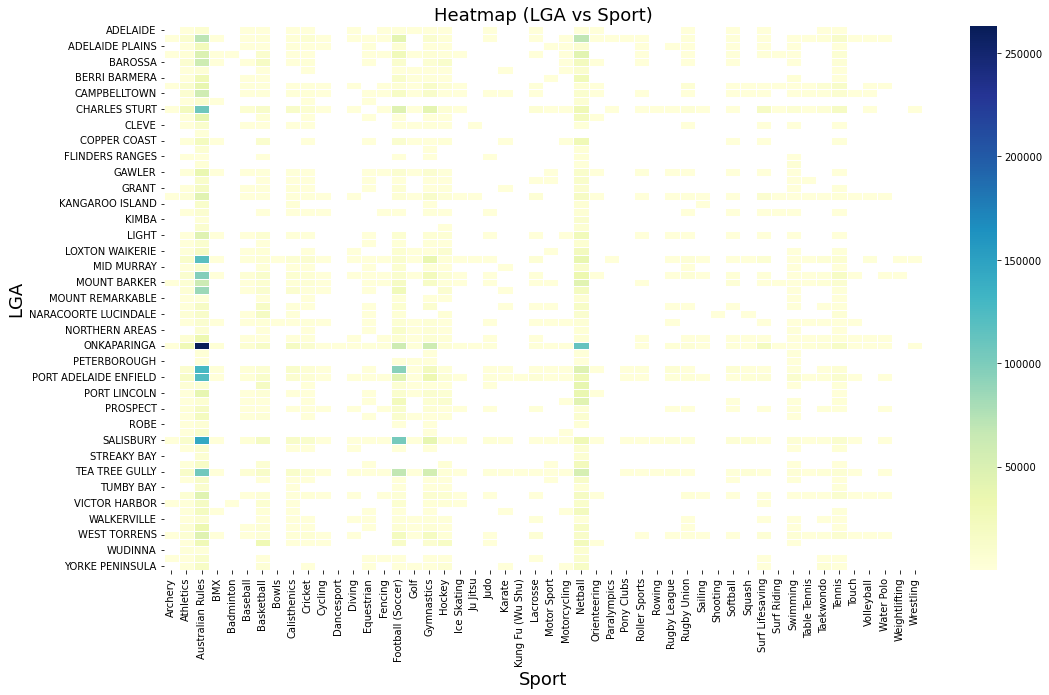

In [120]:
plt.figure(figsize=(17,10))
grid = sns.heatmap(sa_grp,cmap='YlGnBu',linewidths=.5)
grid.set_title(label='Heatmap (LGA vs Sport)',fontsize=18)
grid.set_ylabel('LGA',fontsize=18)
grid.set_xlabel('Sport',fontsize=18)
plt.show()

#### Normalise values to account for significant differences

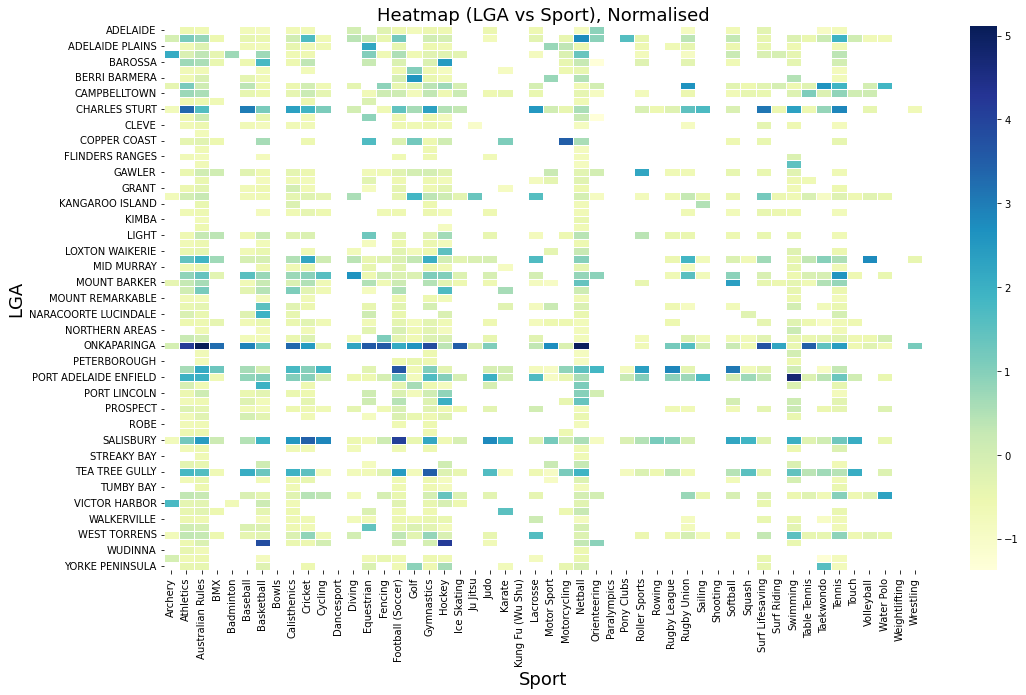

In [119]:
sa_grp_norm = (sa_grp - sa_grp.mean()) / sa_grp.std()

plt.figure(figsize=(17,10))
gridnorm = sns.heatmap(sa_grp_norm,cmap='YlGnBu',linewidths=.5)
gridnorm.set_title(label='Heatmap (LGA vs Sport), Normalised',fontsize=18)
gridnorm.set_ylabel('LGA',fontsize=18)
gridnorm.set_xlabel('Sport',fontsize=18)
plt.show()

### Initial Analysis

- What initially stands out is Onkaparinga, which appears to be heavily involved in a lot of different sports relative to the other LGAs. Meanwhile, other LGAs like Wudinna or Kimba only involve in very little sports.

- It is also worth noting that almost no one in South Australia gets involved in Dancesport, Kung Fu (Wu Shu), Paralympics, and Weightlifting.

- Australian Rules seem to be the most famous sport in South Australia, especially in Onkaparinga, while netball seems to be the top 2 sport in that LGA.

#### Analyse voucher rate

In [52]:
# Pivot table for voucher rate

sa_grp_pct = sa_vouchers_scores.pivot_table(index=['Participant_LGA'],
                                            values=["Voucher_Value","Population"],
                                            aggfunc={'Voucher_Value': 'count',
                                                     'Population': max},
                                            fill_value=0)
sa_grp_pct.columns=['Population', 'Voucher_count']
sa_grp_pct['Voucher_pct'] = sa_grp_pct.Voucher_count/ sa_grp_pct.Population *100
sa_grp_pct.replace(np.inf,np.nan,inplace=True)
sa_grp_pct.dropna(inplace=True)
sa_grp_pct.head()

,Population,Voucher_count,Voucher_pct
Participant_LGA,,,
ADELAIDE,19606,302,1.540345
ADELAIDE HILLS,38601,4756,12.320924
ALEXANDRINA,23693,2979,12.573334
BAROSSA,22174,2874,12.961126
BARUNGA WEST,2467,333,13.498176


In [53]:
pct_plot = sa_grp_pct.sort_values(by=['Voucher_pct'],ascending=False)['Voucher_pct']

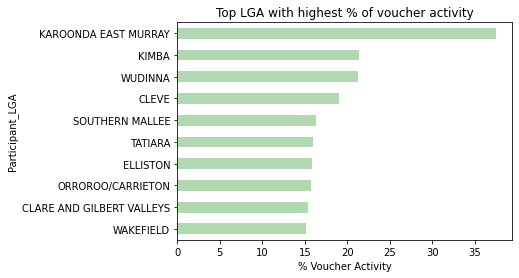

In [54]:
pct_plot = sa_grp_pct.sort_values('Voucher_pct',ascending=False)['Voucher_pct']
pct_plot.head(10).plot(kind='barh',sort_columns=True,color='g',alpha=.3)
plt.title("Top LGA with highest % of voucher activity")
plt.xlabel('% Voucher Activity')
plt.gca().invert_yaxis()

(0.0, 35.0)

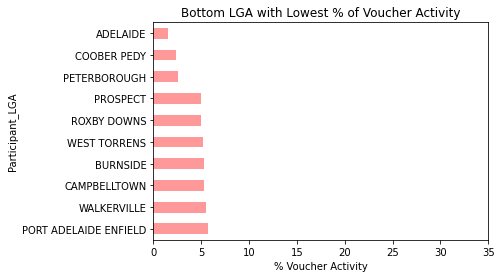

In [55]:
pct_plot.tail(10).plot(kind='barh',sort_columns=True,color='r',alpha=.4)
plt.title("Bottom LGA with Lowest % of Voucher Activity")
plt.xlabel('% Voucher Activity')
plt.xlim(0,35)

#### Check the sports activity of top 10 LGAs with the highest voucher activity per population 

Filter out sports with no voucher claims

In [238]:
criteria = sa_grp[sa_grp.index.isin(pct_plot.index[:10])].notna().any().values
top10rate = sa_grp[sa_grp.index.isin(pct_plot.index[:10])].iloc[:,criteria]

In [259]:
noclaim = sa_grp[sa_grp.index.isin(pct_plot.index[:10])].isna().all()
list(noclaim[noclaim].index)

['Archery',
 'Badminton',
 'Bowls',
 'Dancesport',
 'Ice Skating',
 'Kung Fu (Wu Shu)',
 'Lacrosse',
 'Paralympics',
 'Pony Clubs',
 'Roller Sports',
 'Rowing',
 'Rugby League',
 'Sailing',
 'Shooting',
 'Squash',
 'Table Tennis',
 'Taekwondo',
 'Touch',
 'Volleyball',
 'Water Polo',
 'Weightlifting',
 'Wrestling']

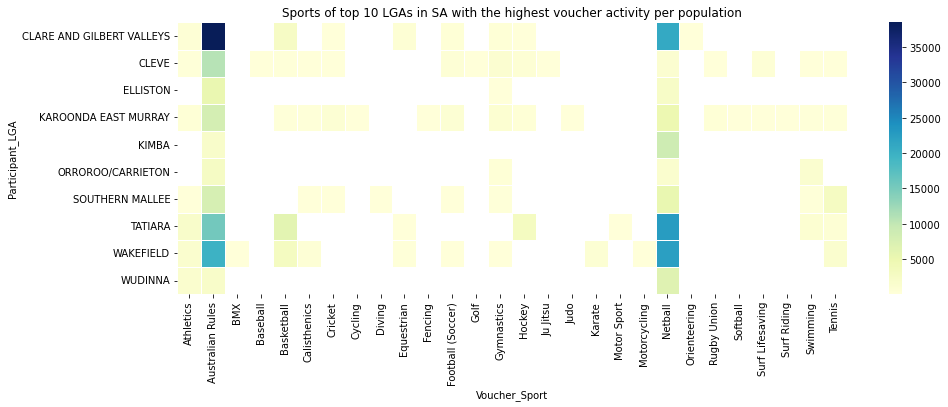

In [262]:
plt.figure(figsize=(15,5))
sns.heatmap(top10rate,cmap='YlGnBu',linewidths=.5)
plt.title('Sports of top 10 LGAs in SA with the highest voucher activity per population')
plt.show()

### Conclusion
Australian Rules and Netball are the 2 most famous sports especially in the top 10 LGAs with high voucher activity per population. However, there are 22 sports that have no voucher claims at all.

# Section 2
Are some sports more popular in different parts of the state?

In [56]:
# Calculate voucher rate per LGA 

# sa_vcount = 
sa_vouchers_scores.pivot_table(index=['Participant_LGA'],
                                        columns='Voucher_Sport',
                                        values="Voucher_Value",
                                        aggfunc={'Voucher_Value':len} )
# sns.heatmap(sa_vcount,cmap='YlGnBu')

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,130.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,257.0,2.0,1.0,1.0,NaN,NaN
ADELAIDE PLAINS,NaN,3.0,485.0,NaN,NaN,3.0,15.0,NaN,23.0,3.0,...,NaN,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,NaN,204.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1196.0,3.0,NaN,6.0,341.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,907.0,2.0,NaN,12.0,70.0,NaN,45.0,85.0,...,NaN,80.0,4.0,27.0,158.0,1.0,4.0,2.0,NaN,NaN
WHYALLA,NaN,15.0,569.0,NaN,NaN,NaN,605.0,NaN,15.0,12.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WUDINNA,NaN,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
sa_vouchers_scores.pivot_table(index=['Participant_LGA'],
                                        columns='Voucher_Sport',
                                        values="Voucher_Value",
                                        aggfunc='count')

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,130.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1412.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,257.0,2.0,1.0,1.0,NaN,NaN
ADELAIDE PLAINS,NaN,3.0,485.0,NaN,NaN,3.0,15.0,NaN,23.0,3.0,...,NaN,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN
ALEXANDRINA,9.0,62.0,980.0,4.0,3.0,NaN,204.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1196.0,3.0,NaN,6.0,341.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,907.0,2.0,NaN,12.0,70.0,NaN,45.0,85.0,...,NaN,80.0,4.0,27.0,158.0,1.0,4.0,2.0,NaN,NaN
WHYALLA,NaN,15.0,569.0,NaN,NaN,NaN,605.0,NaN,15.0,12.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WUDINNA,NaN,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='Participant_LGA'>

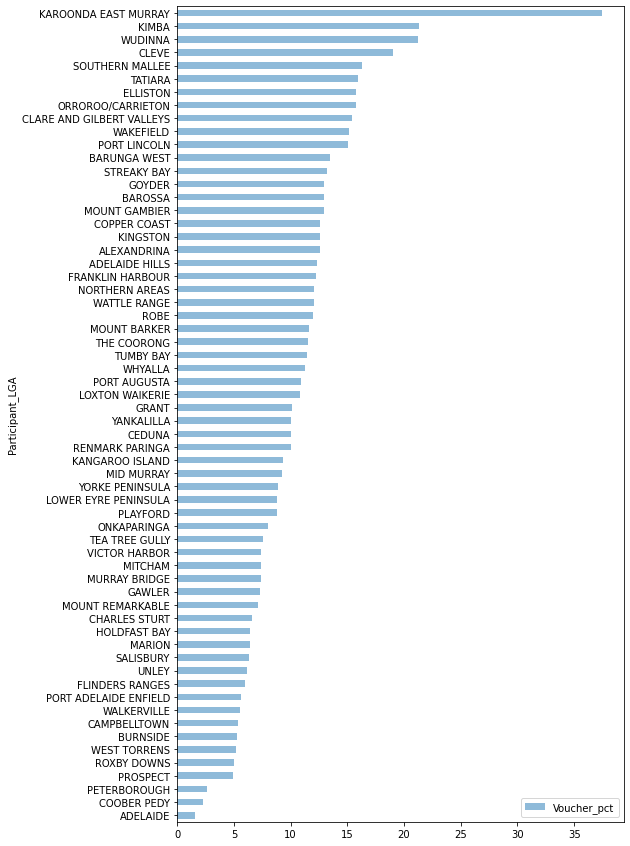

In [58]:

sa_grp_pct.sort_values('Voucher_pct').plot(kind='barh',y='Voucher_pct', figsize=(8,15),alpha=.5)

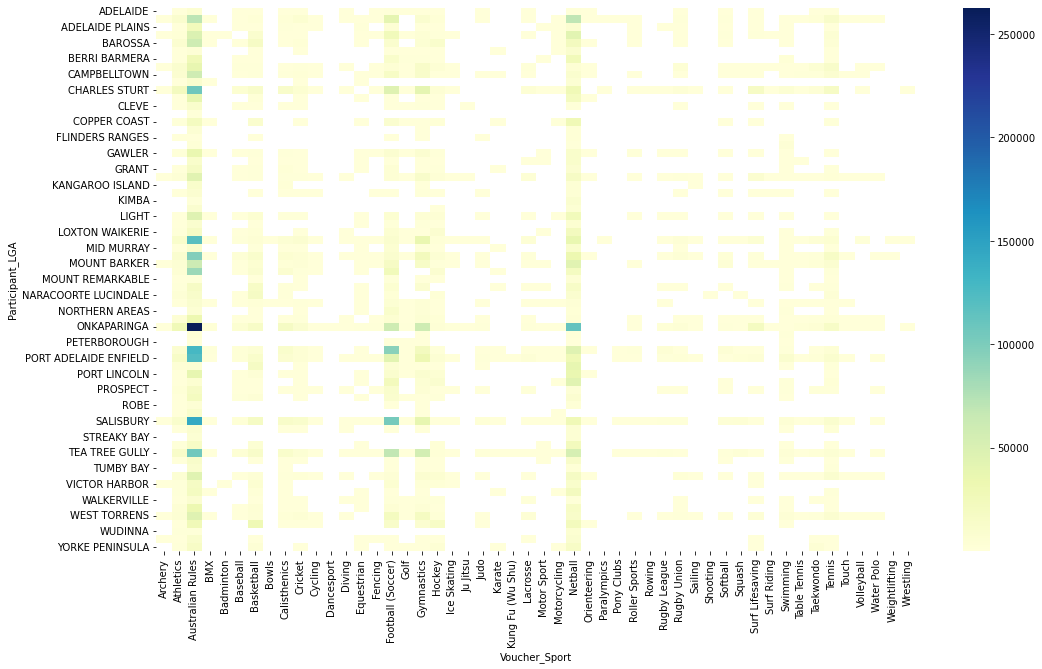

In [59]:
plt.figure(figsize=(17,10))
grid_count = sns.heatmap(sa_grp,cmap='YlGnBu')
grid.set_title(label='Heatmap (LGA vs Sport)',fontsize=18)
grid.set_ylabel('LGA',fontsize=18)
grid.set_xlabel('Sport',fontsize=18)
plt.show()

In [60]:
# Population

sa_vouchers_scores.groupby('Participant_LGA')[['Population']].max()

,Population
Participant_LGA,
ADELAIDE,19606.0
ADELAIDE HILLS,38601.0
ADELAIDE PLAINS,NaN
ALEXANDRINA,23693.0
BAROSSA,22174.0
...,...
WEST TORRENS,54932.0
WHYALLA,22070.0
WUDINNA,1256.0


---

# Section 3

Are any LGAs over/under represented in their use of vouchers?

# Section 4

Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

In [61]:
set(sa_vouchers_scores.Voucher_Claim_Year)

{2015, 2016, 2017}

In [62]:
# Total Voucher Use per LGA
# corr with SEIFA
sa_vouchers_total = sa_vouchers_scores.groupby('Participant_LGA').sum()[['Voucher_Value']]
print('Total LGAs: ',sa_vouchers_total.size)
sa_vouchers_total.head()

Total LGAs:  69


,Voucher_Value
Participant_LGA,
ADELAIDE,15100
ADELAIDE HILLS,237570
ADELAIDE PLAINS,44841
ALEXANDRINA,148790
BAROSSA,143335


In [63]:
sa_index = sa_vouchers_scores.groupby('Participant_LGA').mean()[['IEO','IER','IRSAD','IRSD']]
sa_index.head()

,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0
ADELAIDE PLAINS,NaN,NaN,NaN,NaN
ALEXANDRINA,1000.0,1000.0,969.0,987.0
BAROSSA,1028.0,1028.0,997.0,1017.0


In [64]:
print("The following doesn't have index scores:")
sa_index[sa_index.isna().any(axis=1)]

The following doesn't have index scores:


,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,
ADELAIDE PLAINS,NaN,NaN,NaN,NaN
BERRI BARMERA,NaN,NaN,NaN,NaN
LIGHT,NaN,NaN,NaN,NaN
NARACOORTE LUCINDALE,NaN,NaN,NaN,NaN
NO LGA,NaN,NaN,NaN,NaN
NORWOOD PAYNEHAM AND ST PETERS,NaN,NaN,NaN,NaN
PORT PIRIE,NaN,NaN,NaN,NaN


Double-check to see if there are any NaNs

In [65]:
sa_index.dropna(inplace=True)
sa_index.isna().sum()

IEO      0
IER      0
IRSAD    0
IRSD     0
dtype: int64

Join the index scores and voucher values

In [66]:
sa_voucherindex = sa_vouchers_total.join(sa_index,on='Participant_LGA',how='inner')
sa_voucherindex

,Voucher_Value,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,,
ADELAIDE,15100,874.0,874.0,1036.0,1013.0
ADELAIDE HILLS,237570,1083.0,1083.0,1077.0,1081.0
ALEXANDRINA,148790,1000.0,1000.0,969.0,987.0
BAROSSA,143335,1028.0,1028.0,997.0,1017.0
BARUNGA WEST,15785,981.0,981.0,940.0,954.0
...,...,...,...,...,...
WEST TORRENS,142120,949.0,949.0,989.0,998.0
WHYALLA,120347,905.0,905.0,897.0,905.0
WUDINNA,10190,1008.0,1008.0,999.0,1023.0


Show the scatterplot between Voucher Values and the following Index Types:

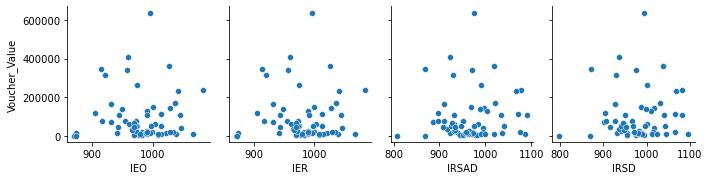

In [67]:
# sns.distplot(sa_voucherindex.IEO)
# sns.distplot(sa_voucherindex.IER)
sns.pairplot(sa_voucherindex,y_vars=['Voucher_Value'], x_vars=['IEO','IER','IRSAD','IRSD'])

#### Use linear model to predict voucher value
Need to transform voucher value

In [68]:
print('Correlation Matrix %')
sa_voucherindex.corr().round(4)*100

Correlation Matrix %


,Voucher_Value,IEO,IER,IRSAD,IRSD
Voucher_Value,100.00,0.62,0.62,5.66,3.65
IEO,0.62,100.00,100.00,77.88,84.64
IER,0.62,100.00,100.00,77.88,84.64
IRSAD,5.66,77.88,77.88,100.00,98.50
IRSD,3.65,84.64,84.64,98.50,100.00


There is an almost non-existent correlation between voucher values and the index scores. However, the index scores themselves have a high correlation between each other.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [69]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [70]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,NaN,NaN,NaN,NaN,NaN
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,NaN,NaN,NaN,NaN,NaN
